# Modelado de los datos

En este notebook se entrenan diferentes modelos en base a los datos limpios de peajes de la Ciudad de Buenos Aires. El objetivo de estos modelos es predecir la cantidad de pasos por hora que habría en cada peaje, partiendo de las características esperadas del “paso” (la fecha de paso, el sentido de viaje, el tipo de vehículo y la forma en la que abonarán el peaje, por ejemplo). 

## Setup de librerías

Se importan las librerías necesarias

In [ ]:
# Librerías estándar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Preprocesamiento y división de datos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Modelos de aprendizaje automático
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Métricas de evaluación
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
# Codificación de variables categóricas
import category_encoders as ce

from itertools import product
from datetime import datetime

## Funciones útiles

A continuación se definen funciones útiles de preprocesamiento y graficación de los datos.

In [13]:
def prepare_dataset(filepath):
    """
    Carga y preprocesa el dataset de peajes.
    """

    dataset = pd.read_csv(filepath)

    # Se separa el día y el mes del año en columnas separadas
    # Necesitamos que las variables sean numéricas
    dataset["nro_dia"] = pd.to_datetime(dataset["fecha"]).dt.day
    dataset["nro_mes"] = pd.to_datetime(dataset["fecha"]).dt.month
    dataset["anio"] = pd.to_datetime(dataset["fecha"]).dt.year
    dataset.drop("fecha", axis=1, inplace=True)

    return dataset

In [14]:
def encode_columns(dataset):
    """
    Codifica las columnas del dataset que tienen variables cualitativas.
    """

    dataset = dataset.copy()

    # Se codifica la categoría día de la semana con label encoding (codificación de etiquetas)
    # Se toma esta decisión porque la variable es ordinal
    day_encoding = {
        'Lunes': 0,
        'Martes': 1,
        'Miercoles': 2,
        'Jueves': 3,
        'Viernes': 4,
        'Sabado': 5,
        'Domingo': 6
    }

    dataset['dia_semana'] = dataset['dia'].map(day_encoding)
    dataset.drop("dia", axis=1, inplace=True)

    # Se codifica el resto de las variables categóricas con binary encoding (codificación binaria)
    binary_encoder = ce.BinaryEncoder(cols=["id_peaje", "sentido", "tipo_vehiculo", "tipo_cobro"])
    dataset = binary_encoder.fit_transform(dataset)
    # Eliminamos las columnas sentido_1 y tipo_vehiculo_1 porque no aportan información
    dataset.drop(["sentido_1", "tipo_vehiculo_1"], axis=1, inplace=True)

    # Cambiarle el nombre a las columnas sentido y tipo_vehículo para saber qué significa cada valor
    dataset.rename(columns={'sentido_0': 'hacia_provincia'}, inplace=True)
    dataset.rename(columns={'tipo_vehiculo_0': 'es_pesado'}, inplace=True)

    return dataset

In [15]:
def get_test_train_data(*x_columns, test_size=0.3, dataset=None):
    """
    Divide el dataset en variables de entrada y salida, y en entrenamiento y prueba.
    """
    if "all" in x_columns:
        x_columns = ['hora', 
                     'id_peaje_0', 'id_peaje_1', 'id_peaje_2', 
                     'hacia_provincia', 'es_pesado', 
                     'tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 'tipo_cobro_3', 
                     'nro_dia', 'nro_mes', 'anio', 'dia_semana']
    x = dataset[list(x_columns)]  
    y = dataset['pasos'] 

    # Se normalizan las variables
    scaler = StandardScaler()
    x_scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

    print(x_scaled)
    # Se divide el dataset en entrenamiento y prueba
    x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=42)
    return x_train, y_train, x_test, y_test

In [16]:
def graph_predictions(y_test, y_pred):
    """
    Grafica los resultados de un modelo entrenado y muestra sus métricas
    """
    # Evaluar el modelo
    mse = pow(root_mean_squared_error(y_test, y_pred), 2)
    print("Error cuadrático medio (MSE):", mse)

    # Raíz del Error Cuadrático Medio (RMSE - Root Mean Squared Error)
    rmse = np.sqrt(mse)

    # Error Absoluto Medio (MAE - Mean Absolute Error)
    mae = mean_absolute_error(y_test, y_pred)

    # R² (Coeficiente de Determinación):
    r2 = r2_score(y_test, y_pred)

    # Error Absoluto Medio Porcentual (MAPE - Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Imprimir las métricas
    print("Raíz del Error Cuadrático Medio (RMSE):", rmse)
    print("Error Absoluto Medio (MAE):", mae)
    print("Coeficiente de Determinación (R²):", r2)
    print("Error Absoluto Medio Porcentual (MAPE):", mape)


    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Identidad')
    plt.legend(loc='upper left')
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title('Gráfico de Dispersión: Valores Reales vs Predicciones')
    plt.show()

    # Gráfico de Residuos (Residual Plot). Muestra los residuos (diferencias entre los valores reales y las predicciones) en función de las predicciones.
    residuals = y_test - y_pred

    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='r', linestyle='--', label='Error ideal')  # Línea en y=0
    plt.legend(loc='upper left')
    plt.xlabel('Predicciones')
    plt.ylabel('Residuos')
    plt.title('Gráfico de Residuos')
    plt.show()

## Carga del dataset

In [17]:
dataset_original = prepare_dataset("clean_data.csv")
dataset = encode_columns(dataset_original)
dataset.info()
dataset.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4473491 entries, 0 to 4473490
Data columns (total 15 columns):
 #   Column           Dtype  
---  ------           -----  
 0   hora             float64
 1   id_peaje_0       int64  
 2   id_peaje_1       int64  
 3   id_peaje_2       int64  
 4   hacia_provincia  int64  
 5   es_pesado        int64  
 6   tipo_cobro_0     int64  
 7   tipo_cobro_1     int64  
 8   tipo_cobro_2     int64  
 9   tipo_cobro_3     int64  
 10  pasos            int64  
 11  nro_dia          int32  
 12  nro_mes          int32  
 13  anio             int32  
 14  dia_semana       int64  
dtypes: float64(1), int32(3), int64(11)
memory usage: 460.8 MB


,hora,id_peaje_0,id_peaje_1,id_peaje_2,hacia_provincia,es_pesado,tipo_cobro_0,tipo_cobro_1,tipo_cobro_2,tipo_cobro_3,pasos,nro_dia,nro_mes,anio,dia_semana
0,0.0,0,0,1,0,0,0,0,0,1,32,1,1,2016,4
1,16.0,0,1,0,0,1,0,0,1,0,22,1,1,2016,4
2,16.0,0,1,0,0,0,0,0,1,1,8,1,1,2016,4
3,16.0,0,1,0,0,0,0,1,0,0,213,1,1,2016,4
4,16.0,0,1,0,0,0,0,0,0,1,4,1,1,2016,4
5,16.0,0,1,0,0,0,0,1,0,1,1,1,1,2016,4
6,16.0,0,1,0,0,0,0,1,1,0,2,1,1,2016,4
7,16.0,0,1,0,0,0,0,0,1,0,676,1,1,2016,4
8,16.0,0,1,1,0,1,0,1,0,0,24,1,1,2016,4
9,16.0,0,1,1,0,1,0,0,1,0,21,1,1,2016,4


## Regresión lineal múltiple

Antes de realizar la regresión, se busca la correlación entre cada variable y la variable "pasos".

In [18]:
# Calcular la correlación con la variable objetivo 'pasos'
correlation_with_target = dataset.corr()['pasos'].drop('pasos')

# Como tipo_cobro y id_peaje están codificadas, se las agrupa y se toma su media de correlación
tipo_cobro_columns = ['tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 'tipo_cobro_3'] 
id_peaje_columns = ['id_peaje_0', 'id_peaje_1', 'id_peaje_2']  
tipo_cobro_correlation = correlation_with_target[tipo_cobro_columns].mean()
id_peaje_correlation = correlation_with_target[id_peaje_columns].mean()
correlation_with_target = correlation_with_target.drop(tipo_cobro_columns + id_peaje_columns)

# Agregar las correlaciones agrupadas al final de la lista y se ordena
correlation_with_target['tipo_cobro'] = tipo_cobro_correlation
correlation_with_target['id_peaje'] = id_peaje_correlation
correlation_with_target = correlation_with_target.abs().sort_values(ascending=False)

print("Correlación de cada variable con 'pasos':")
print(correlation_with_target)

Correlación de cada variable con 'pasos':
es_pesado          0.224693
tipo_cobro         0.096955
hora               0.061210
hacia_provincia    0.047437
anio               0.039962
id_peaje           0.035942
dia_semana         0.018231
nro_mes            0.012046
nro_dia            0.008122
Name: pasos, dtype: float64


Las variables que presentaron mayor correlación fueron el tipo de vehículo (codificada con un 0 o un 1 según si es o no pesado), el tipo de cobro y la hora.

Se construyó un modelo de regresión lineal con esos valores y se obtuvieron sus resultados.

### Regresión lineal múltiple con columnas seleccionadas

             hora  es_pesado  tipo_cobro_0  tipo_cobro_1  tipo_cobro_2  \
0       -1.834284  -0.803574     -0.024406     -1.256865     -1.095853   
1        0.602141   1.244441     -0.024406     -1.256865      0.912531   
2        0.602141  -0.803574     -0.024406     -1.256865      0.912531   
3        0.602141  -0.803574     -0.024406      0.795630     -1.095853   
4        0.602141  -0.803574     -0.024406     -1.256865     -1.095853   
...           ...        ...           ...           ...           ...   
4473486 -0.616072  -0.803574     -0.024406      0.795630      0.912531   
4473487 -0.616072  -0.803574     -0.024406      0.795630     -1.095853   
4473488 -0.616072  -0.803574     -0.024406      0.795630     -1.095853   
4473489 -0.616072  -0.803574     -0.024406     -1.256865     -1.095853   
4473490  1.668076  -0.803574     -0.024406      0.795630     -1.095853   

         tipo_cobro_3  
0             1.09761  
1            -0.91107  
2             1.09761  
3            -0

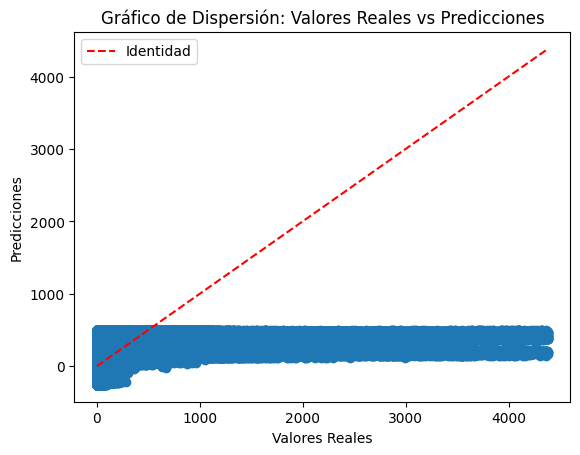

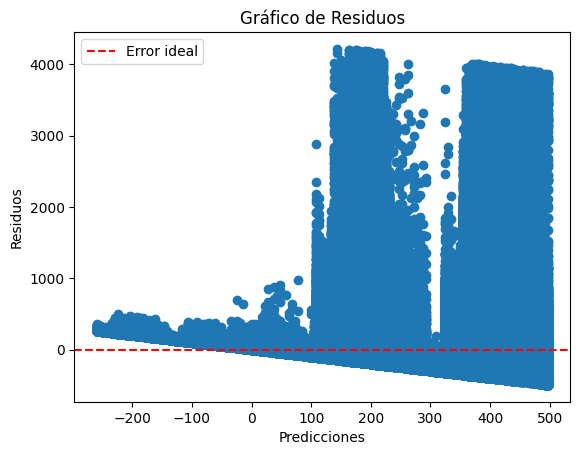

In [19]:
x_train, y_train, x_test, y_test = get_test_train_data('hora', 
                     'es_pesado', 
                     'tipo_cobro_0', 'tipo_cobro_1', 'tipo_cobro_2', 'tipo_cobro_3',
                     dataset=dataset)

# Instanciar el modelo
linear_model = LinearRegression()

# Entrenar el modelo
linear_model.fit(x_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = linear_model.predict(x_test)

graph_predictions(y_test, y_pred)

Como el error total fue demasiado alto, se decidió probar con distintas combinaciones de las variables predictoras. El modelo que logró el mejor resultado fue el que utilizó todas las variables posibles.

### Regresión lineal múltiple con dataset completo

             hora  id_peaje_0  id_peaje_1  id_peaje_2  hacia_provincia  \
0       -1.834284   -0.895643   -0.988214    1.116382        -1.044956   
1        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
2        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
3        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
4        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
...           ...         ...         ...         ...              ...   
4473486 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473487 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473488 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473489 -0.616072   -0.895643    1.011927    1.116382        -1.044956   
4473490  1.668076    1.116517   -0.988214    1.116382         0.956978   

         es_pesado  tipo_cobro_0  tipo_cobro_1  tipo_cobro_2  tipo_cobro_3  \
0        -0.803574     -0.024406 

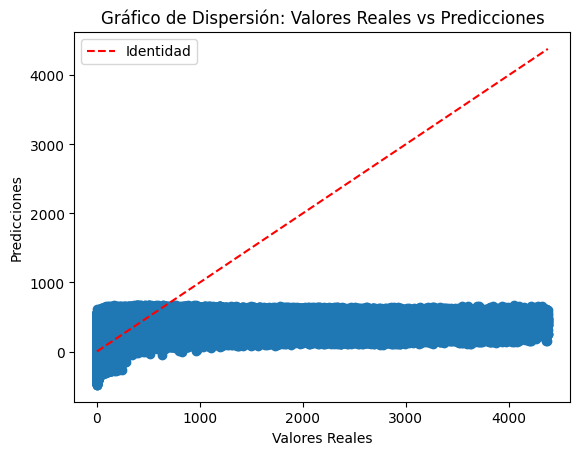

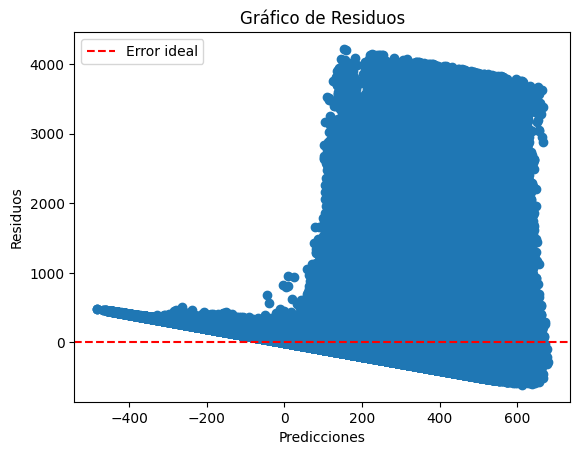

In [20]:
x_train, y_train, x_test, y_test = get_test_train_data("all", dataset=dataset)


# Instanciar el modelo
linear_model = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)

# Entrenar el modelo
linear_model.fit(x_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = linear_model.predict(x_test)

graph_predictions(y_test, y_pred)

## Árbol de decisión

Se hizo la prueba con árboles de distintas profundidades para encontrar el que mejor se ajustara a los datos.

In [21]:
depths = [5, 10, 15, 20, 25, 30]
scores = []
x_train, y_train, x_test, y_test = get_test_train_data("all", dataset=dataset)

for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(x_train, y_train)
    score = model.score(x_test, y_test)
    scores.append(score)
    print(f"Max depth: {depth}, R² score: {score:.3f}")



             hora  id_peaje_0  id_peaje_1  id_peaje_2  hacia_provincia  \
0       -1.834284   -0.895643   -0.988214    1.116382        -1.044956   
1        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
2        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
3        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
4        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
...           ...         ...         ...         ...              ...   
4473486 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473487 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473488 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473489 -0.616072   -0.895643    1.011927    1.116382        -1.044956   
4473490  1.668076    1.116517   -0.988214    1.116382         0.956978   

         es_pesado  tipo_cobro_0  tipo_cobro_1  tipo_cobro_2  tipo_cobro_3  \
0        -0.803574     -0.024406 

El que mejor rendimiento produjo es el de max_depth de 20.

             hora  id_peaje_0  id_peaje_1  id_peaje_2  hacia_provincia  \
0       -1.834284   -0.895643   -0.988214    1.116382        -1.044956   
1        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
2        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
3        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
4        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
...           ...         ...         ...         ...              ...   
4473486 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473487 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473488 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473489 -0.616072   -0.895643    1.011927    1.116382        -1.044956   
4473490  1.668076    1.116517   -0.988214    1.116382         0.956978   

         es_pesado  tipo_cobro_0  tipo_cobro_1  tipo_cobro_2  tipo_cobro_3  \
0        -0.803574     -0.024406 

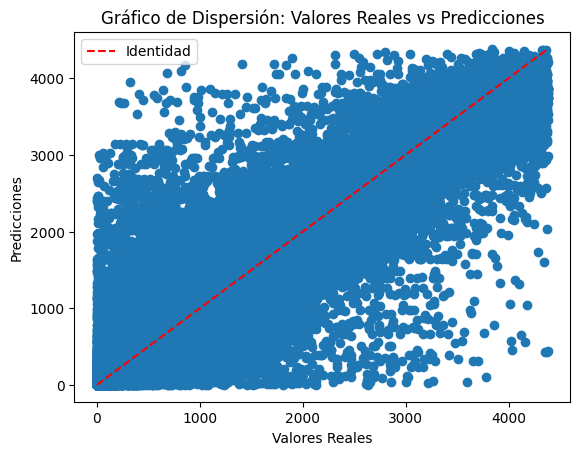

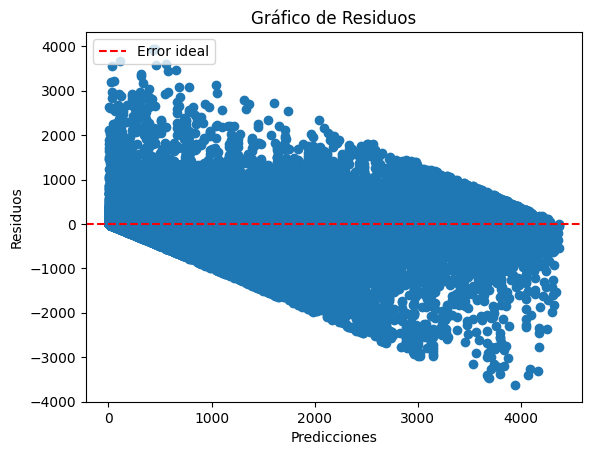

In [22]:
x_train, y_train, x_test, y_test = get_test_train_data("all", dataset=dataset)

# Instanciar y entrenar el modelo
tree_model = DecisionTreeRegressor(criterion="squared_error",
                                 max_depth=20,
                                 min_samples_leaf=1,
                                 min_samples_split=2,
                                 max_features=None,
                                 random_state=42)
tree_model.fit(x_train, y_train)

# Predecir en el conjunto de prueba
y_pred_rf = tree_model.predict(x_test)

graph_predictions(y_test, y_pred_rf)

## Random forest

Se esperaba que el random forest obtuviera mejores resultados por su capacidad de identificar relaciones no lineales entre las variables.

             hora  id_peaje_0  id_peaje_1  id_peaje_2  hacia_provincia  \
0       -1.834284   -0.895643   -0.988214    1.116382        -1.044956   
1        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
2        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
3        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
4        0.602141   -0.895643    1.011927   -0.895751        -1.044956   
...           ...         ...         ...         ...              ...   
4473486 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473487 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473488 -0.616072    1.116517   -0.988214    1.116382         0.956978   
4473489 -0.616072   -0.895643    1.011927    1.116382        -1.044956   
4473490  1.668076    1.116517   -0.988214    1.116382         0.956978   

         es_pesado  tipo_cobro_0  tipo_cobro_1  tipo_cobro_2  tipo_cobro_3  \
0        -0.803574     -0.024406 

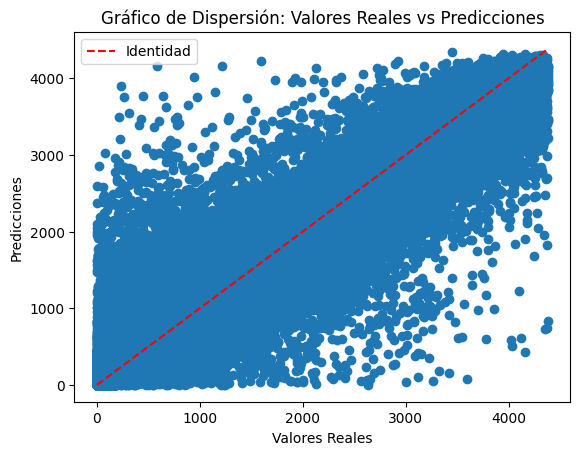

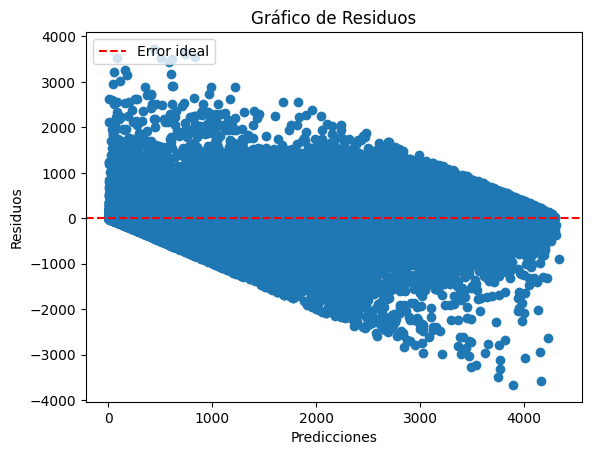

In [23]:
x_train, y_train, x_test, y_test = get_test_train_data("all", dataset=dataset)

# Instanciar y entrenar el modelo
rf_model = RandomForestRegressor(n_estimators=10,
                                 max_depth=None,
                                 random_state=42)
rf_model.fit(x_train, y_train)

# Predecir en el conjunto de prueba
y_pred_rf = rf_model.predict(x_test)

graph_predictions(y_test, y_pred_rf)

Se probaron diferentes combinaciones de parámetros para limitar la sensibilidad al ruido y generalizar mejor los datos. Sin embargo, esta parametrización fue la que mejor resultado dio.

## Muestra de funcionamiento de los modelos

Para apreciar visualmente cómo reacciona cada uno de los modelos a los distintos valores de entradas, se seleccionarán del dataset de 2024 algunos valores aleatorios y se mostrará la entrada, la predicción del modelo y la salida esperada.

In [24]:
def predict_and_show(model, x, y, dict_errors):
    """
    Realiza predicciones con un modelo y muestra los resultados.
    """

    x_df = pd.DataFrame([x])
    scaler = StandardScaler()
    x_df = pd.DataFrame(scaler.fit_transform(x_df), columns=x_df.columns)

    y_pred = model.predict(x_df)
    abs_err = abs(y - y_pred[0])
    
    print("Entrada:")
    print(x)
    print("\nSalida esperada:", y)
    print("Predicción del modelo:", y_pred[0])
    print("Error absoluto:", abs_err)
    print()

    dict_errors[str(model)].append(abs_err)


### Carga del Dataset 2024
Se hace la carga del dataset limpiado en la entrega dos para hacer las predicciones correspondientes

In [25]:
# Carga la data del 2024

data_2024 = encode_columns(prepare_dataset("clean_data_2024.csv"))

### Predicciones para el año 2024
Se realizan las redicciones respecto a datos extraidos del 2024 y se realiza la predicción con los tres modelos entrenados anteriormente.

In [26]:

# Se obtienen algunas muestras aleatorias del dataset
sampled_data_2024 = data_2024.sample(1000)
dict_errors = {}

for model in [linear_model, tree_model, rf_model]:
    print()
    print("---------------")
    print(model)
    dict_errors.update({str(model): []})

    for i, row in sampled_data_2024.iterrows():
        x = row.drop("pasos")
        y = row["pasos"]
        predict_and_show(model, x, y, dict_errors)

print("Errores absolutos de cada modelo en estas muestras:")
for model, errors in dict_errors.items():
    print(f"\t{model}: {np.mean(errors)}")


---------------
LinearRegression()
Entrada:
hora                  0
id_peaje_0            0
id_peaje_1            1
id_peaje_2            0
hacia_provincia       1
es_pesado             0
tipo_cobro_0          0
tipo_cobro_1          1
tipo_cobro_2          0
tipo_cobro_3          0
nro_dia              10
nro_mes               1
anio               2024
dia_semana            2
Name: 11903, dtype: int64

Salida esperada: 499
Predicción del modelo: 180.75152111559476
Error absoluto: 318.24847888440524

Entrada:
hora                 16
id_peaje_0            0
id_peaje_1            0
id_peaje_2            1
hacia_provincia       0
es_pesado             0
tipo_cobro_0          0
tipo_cobro_1          1
tipo_cobro_2          0
tipo_cobro_3          0
nro_dia              10
nro_mes               7
anio               2024
dia_semana            2
Name: 235781, dtype: int64

Salida esperada: 604
Predicción del modelo: 180.75152111559476
Error absoluto: 423.24847888440524

Entrada:
hora        

# Predicción 2025
Vamos a utilizar nuestro modelo para predecir un año que aún no transcurrió, para tener una idea de cómo será el comportamiento a futuro utilizando el historial y nuestros modelos de predicción.

### Generación de dataset vacío
Para poder realizar las predicciones, primero necesitamos generar un dataset con la columna de pasos vacía, para que nuestro modelo tenga valores de entrada para las cuales predecir. Vamos a crear un dataframe exhaustivo con todas las combinaciones posibles de hora, día, tipo de vehículo, tipo de cobro, peaje y sentido.

In [27]:
# Define the range for dates in 2025
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 12, 31)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Define the weekdays in Spanish
dias = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']

# Map dates to corresponding weekdays
dates = [(fecha.strftime('%Y-%m-%d'), dias[fecha.weekday()]) for fecha in date_range]

# Define exhaustive lists for each other column
horas = np.arange(0.0, 24.0, 1.0)    # Decimal hours from 0.0 to 23.0
id_peaje = ['ALB', 'AVE', 'DEC', 'ILL', 'RET', 'SAL', 'SAR']
sentido = ['Centro', 'Provincia']
tipo_vehiculo = ['Liviano', 'Pesado']
tipo_cobro = ['Tag', 'Efectivo', 'Monedero virtual', 'Rec. Deuda', 'Exento', 'Tarjeta Magnetica', 'Infraccion', 'Otro']

# Create all combinations of other columns
combinations = list(product(horas, id_peaje, sentido, tipo_vehiculo, tipo_cobro))

# Expand each date to all combinations of other columns
data = []
for fecha, dia in dates:
    for combo in combinations:
        data.append((fecha, dia, *combo))

# Create DataFrame
columns = ['fecha', 'dia', 'hora', 'id_peaje', 'sentido', 'tipo_vehiculo', 'tipo_cobro']
df = pd.DataFrame(data, columns=columns)

# Display part of the DataFrame to confirm
print(df.head())
print(f"DataFrame size: {df.shape}")

df.to_csv("2025empty.csv", index=False)

        fecha        dia  hora id_peaje sentido tipo_vehiculo  \
0  2025-01-01  Miercoles   0.0      ALB  Centro       Liviano   
1  2025-01-01  Miercoles   0.0      ALB  Centro       Liviano   
2  2025-01-01  Miercoles   0.0      ALB  Centro       Liviano   
3  2025-01-01  Miercoles   0.0      ALB  Centro       Liviano   
4  2025-01-01  Miercoles   0.0      ALB  Centro       Liviano   

         tipo_cobro  
0               Tag  
1          Efectivo  
2  Monedero virtual  
3        Rec. Deuda  
4            Exento  
DataFrame size: (1962240, 7)


### Codificación de columnas
Para poder realizar la inferencia, nuestros modelos de predicción esperan que todas las columnas sean numéricas, por lo que hay que codificarlas con la misma función que el dataset de entrenamiento.

In [28]:
dataset2025_original = prepare_dataset("2025empty.csv")
dataset2025 = encode_columns(dataset2025_original)

### Inferencia
Escalaremos los valores del dataset y realizaremos la predicción, mostrando cómo quedaría el dataset de salida.

In [29]:
scaler = StandardScaler()
dataset2025_scaled = pd.DataFrame(scaler.fit_transform(dataset2025), columns=dataset2025.columns)
y_pred = rf_model.predict(dataset2025_scaled)

In [30]:
dataset2025['pasos'] = y_pred
dataset2025

,hora,id_peaje_0,id_peaje_1,id_peaje_2,hacia_provincia,es_pesado,tipo_cobro_0,tipo_cobro_1,tipo_cobro_2,tipo_cobro_3,nro_dia,nro_mes,anio,dia_semana,pasos
0,0.0,0,0,1,0,0,0,0,0,1,1,1,2025,2,36.9
1,0.0,0,0,1,0,0,0,0,1,0,1,1,2025,2,35.6
2,0.0,0,0,1,0,0,0,0,1,1,1,1,2025,2,1.5
3,0.0,0,0,1,0,0,0,1,0,0,1,1,2025,2,31.6
4,0.0,0,0,1,0,0,0,1,0,1,1,1,2025,2,15.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962235,23.0,1,1,1,1,1,0,1,0,0,31,12,2025,2,2.7
1962236,23.0,1,1,1,1,1,0,1,0,1,31,12,2025,2,1.2
1962237,23.0,1,1,1,1,1,0,1,1,0,31,12,2025,2,1.6
1962238,23.0,1,1,1,1,1,0,1,1,1,31,12,2025,2,1.3


### Decodificación
Como vemos, la predicción se hizo pero el dataset no es legible para ojos humanos, con lo cual haremos el proceso inverso a la codificación para poder entenderlo y que el formato coincida con los datasets originales.

In [31]:
def decode_columns(dataset):
    """
    Decodifica las columnas del dataset que fueron codificadas.
    """

    dataset = dataset.copy()

    # Día de la semana
    day_decoding = {
        0: 'Lunes',
        1: 'Martes',
        2: 'Miercoles',
        3: 'Jueves',
        4: 'Viernes',
        5: 'Sabado',
        6: 'Domingo'
    }
    dataset['dia'] = dataset['dia_semana'].map(day_decoding)
    dataset.drop('dia_semana', axis=1, inplace=True)

    # Tipo
    type_decoding = {
        0: 'Liviano',
        1: 'Pesado'
    }
    dataset['tipo_vehiculo'] = dataset['es_pesado'].map(type_decoding)
    dataset.drop('es_pesado', axis=1, inplace=True)

    # Sentido
    direction_decoding = {
        0: 'Centro',
        1: 'Provincia'
    }
    dataset['sentido'] = dataset['hacia_provincia'].map(direction_decoding)
    dataset.drop('hacia_provincia', axis=1, inplace=True)

    # ALB 1
    # ILL 10
    # DEC 11
    # AVE 100
    # SAR 101
    # SAL 110
    # RET 111

    # Peaje
    toll_conditions = [
        (dataset['id_peaje_0'] == 0) & (dataset['id_peaje_1'] == 0) & (dataset['id_peaje_2'] == 1),
        (dataset['id_peaje_0'] == 0) & (dataset['id_peaje_1'] == 1) & (dataset['id_peaje_2'] == 0),
        (dataset['id_peaje_0'] == 0) & (dataset['id_peaje_1'] == 1) & (dataset['id_peaje_2'] == 1),
        (dataset['id_peaje_0'] == 1) & (dataset['id_peaje_1'] == 0) & (dataset['id_peaje_2'] == 0),
        (dataset['id_peaje_0'] == 1) & (dataset['id_peaje_1'] == 0) & (dataset['id_peaje_2'] == 1),
        (dataset['id_peaje_0'] == 1) & (dataset['id_peaje_1'] == 1) & (dataset['id_peaje_2'] == 0),
        (dataset['id_peaje_0'] == 1) & (dataset['id_peaje_1'] == 1) & (dataset['id_peaje_2'] == 1)
    ]
    toll_values = ['ALB', 'ILL', 'DEC', 'AVE', 'SAR', 'SAL', 'RET']
    dataset['id_peaje'] = np.select(toll_conditions, toll_values, default='Unknown')
    dataset.drop('id_peaje_0', axis=1, inplace=True)
    dataset.drop('id_peaje_1', axis=1, inplace=True)
    dataset.drop('id_peaje_2', axis=1, inplace=True)

    # Rec.Deuda 1
    # Efectivo 10
    # Tarjeta Magnetica 11
    # Tag 100
    # Monedero virtual 101
    # Infraccion 110
    # Exento 111
    # Otro 1000

    # Tipo de cobro
    payment_conditions = [
        (dataset['tipo_cobro_0'] == 0) & (dataset['tipo_cobro_1'] == 0) & (dataset['tipo_cobro_2'] == 0) & (dataset['tipo_cobro_3'] == 1),
        (dataset['tipo_cobro_0'] == 0) & (dataset['tipo_cobro_1'] == 0) & (dataset['tipo_cobro_2'] == 1) & (dataset['tipo_cobro_3'] == 0),
        (dataset['tipo_cobro_0'] == 0) & (dataset['tipo_cobro_1'] == 0) & (dataset['tipo_cobro_2'] == 1) & (dataset['tipo_cobro_3'] == 1),
        (dataset['tipo_cobro_0'] == 0) & (dataset['tipo_cobro_1'] == 1) & (dataset['tipo_cobro_2'] == 0) & (dataset['tipo_cobro_3'] == 0),
        (dataset['tipo_cobro_0'] == 0) & (dataset['tipo_cobro_1'] == 1) & (dataset['tipo_cobro_2'] == 0) & (dataset['tipo_cobro_3'] == 1),
        (dataset['tipo_cobro_0'] == 0) & (dataset['tipo_cobro_1'] == 1) & (dataset['tipo_cobro_2'] == 1) & (dataset['tipo_cobro_3'] == 0),
        (dataset['tipo_cobro_0'] == 0) & (dataset['tipo_cobro_1'] == 1) & (dataset['tipo_cobro_2'] == 1) & (dataset['tipo_cobro_3'] == 1),
        (dataset['tipo_cobro_0'] == 1) & (dataset['tipo_cobro_1'] == 0) & (dataset['tipo_cobro_2'] == 0) & (dataset['tipo_cobro_3'] == 0)
    ]
    payment_values = ['Rec.Deuda', 'Efectivo', 'Tarjeta Magnetica', 'Tag', 'Monedero virtual', 'Infraccion', 'Exento', 'Otro']
    dataset['tipo_cobro'] = np.select(payment_conditions, payment_values, default='Unknown')
    dataset.drop('tipo_cobro_0', axis=1, inplace=True)
    dataset.drop('tipo_cobro_1', axis=1, inplace=True)
    dataset.drop('tipo_cobro_2', axis=1, inplace=True)
    dataset.drop('tipo_cobro_3', axis=1, inplace=True)

    # Eliminar tipo de pago "Otro"
    dataset = dataset[dataset["tipo_cobro"] != "Otro"]

    return dataset

decoded_dataset = decode_columns(dataset2025)
decoded_dataset.info()
decoded_dataset.sample(30)

<class 'pandas.core.frame.DataFrame'>
Index: 1716960 entries, 0 to 1962238
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   hora           float64
 1   nro_dia        int32  
 2   nro_mes        int32  
 3   anio           int32  
 4   pasos          float64
 5   dia            object 
 6   tipo_vehiculo  object 
 7   sentido        object 
 8   id_peaje       object 
 9   tipo_cobro     object 
dtypes: float64(2), int32(3), object(5)
memory usage: 124.4+ MB


,hora,nro_dia,nro_mes,anio,pasos,dia,tipo_vehiculo,sentido,id_peaje,tipo_cobro
1800649,22.0,1,12,2025,34.1,Lunes,Pesado,Centro,SAR,Efectivo
763603,0.0,23,5,2025,3.8,Viernes,Liviano,Provincia,RET,Tag
434569,20.0,22,3,2025,2.1,Sabado,Pesado,Centro,ALB,Efectivo
1520014,17.0,10,10,2025,7.4,Viernes,Pesado,Centro,SAL,Exento
482115,16.0,31,3,2025,633.1,Lunes,Liviano,Centro,DEC,Tag
1133089,18.0,30,7,2025,1683.6,Miercoles,Liviano,Centro,AVE,Efectivo
819660,11.0,2,6,2025,1.4,Lunes,Pesado,Centro,ILL,Monedero virtual
1675651,16.0,8,11,2025,248.1,Sabado,Liviano,Centro,SAR,Tag
1517530,6.0,10,10,2025,1.1,Viernes,Pesado,Provincia,SAR,Tarjeta Magnetica
1438860,15.0,25,9,2025,18.0,Jueves,Pesado,Centro,AVE,Monedero virtual


### Resumen con matplotlib


    Hallazgos Clave para las Proyecciones 2025:
    
    1. Volumen de Tráfico:
       - Total proyectado: 180,517,042 pasos
       - Promedio diario: 105 pasos
    
    2. Patrones Temporales:
       - Mes de mayor actividad: Diciembre
       - Hora pico: 17:00
       - Día más transitado: Viernes
    
    3. Composición del Tráfico:
       - Tipo de vehículo predominante: Liviano
       - Estación de peaje más activa: ('AVE', 'Centro')
       - Método de pago más común: Efectivo
    


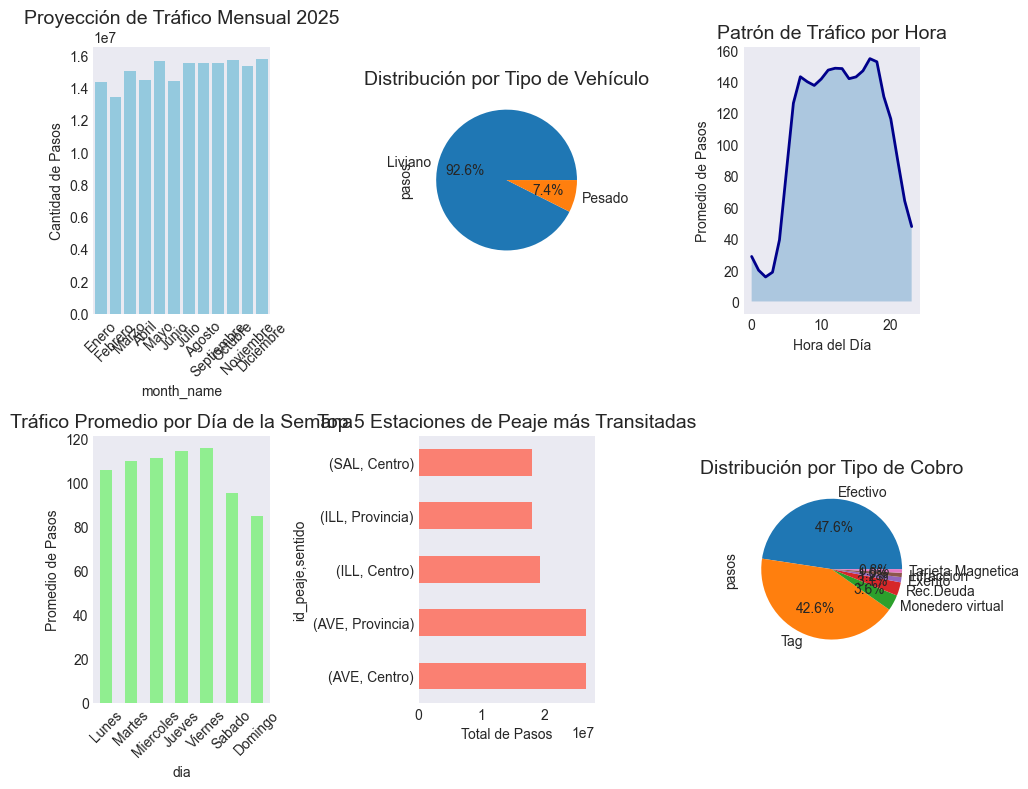

In [39]:
import seaborn as sns

def analyze_toll_data(df):
    # 1. Monthly traffic analysis
    monthly_traffic = df.groupby('nro_mes')['pasos'].sum().reset_index()
    monthly_traffic['month_name'] = monthly_traffic['nro_mes'].map({
        1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 
        5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto',
        9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
    })
    
    # 2. Vehicle type distribution
    vehicle_dist = df.groupby('tipo_vehiculo')['pasos'].sum().sort_values(ascending=False)
    
    # 3. Peak hours analysis
    hourly_traffic = df.groupby('hora')['pasos'].mean().reset_index()
    
    # 4. Day of week analysis
    day_order = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']
    daily_traffic = df.groupby('dia')['pasos'].mean().reindex(day_order)
    
    # 5. Toll station analysis
    station_traffic = df.groupby(['id_peaje', 'sentido'])['pasos'].sum().sort_values(ascending=False)
    
    # 6. Payment type analysis
    payment_dist = df.groupby('tipo_cobro')['pasos'].sum().sort_values(ascending=False)
    
    # Create a figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Monthly Traffic Trend
    ax1 = plt.subplot(2, 3, 1)
    sns.barplot(data=monthly_traffic, x='month_name', y='pasos', color='skyblue')
    plt.title('Proyección de Tráfico Mensual 2025', fontsize=14)
    plt.xticks(rotation=45)
    plt.ylabel('Cantidad de Pasos')
    
    # 2. Vehicle Type Distribution
    ax2 = plt.subplot(2, 3, 2)
    vehicle_dist.plot(kind='pie', autopct='%1.1f%%', figsize=(10, 8))
    plt.title('Distribución por Tipo de Vehículo', fontsize=14)
    
    # 3. Average Daily Pattern
    ax3 = plt.subplot(2, 3, 3)
    sns.lineplot(data=hourly_traffic, x='hora', y='pasos', color='darkblue', linewidth=2)
    plt.fill_between(hourly_traffic['hora'], hourly_traffic['pasos'], alpha=0.3)
    plt.title('Patrón de Tráfico por Hora', fontsize=14)
    plt.xlabel('Hora del Día')
    plt.ylabel('Promedio de Pasos')
    
    # 4. Day of Week Pattern
    ax4 = plt.subplot(2, 3, 4)
    daily_traffic.plot(kind='bar', color='lightgreen')
    plt.title('Tráfico Promedio por Día de la Semana', fontsize=14)
    plt.xticks(rotation=45)
    plt.ylabel('Promedio de Pasos')
    
    # 5. Top 5 Busiest Toll Stations
    ax5 = plt.subplot(2, 3, 5)
    top_stations = station_traffic.head(5)
    top_stations.plot(kind='barh', color='salmon')
    plt.title('Top 5 Estaciones de Peaje más Transitadas', fontsize=14)
    plt.xlabel('Total de Pasos')
    
    # 6. Payment Type Distribution
    ax6 = plt.subplot(2, 3, 6)
    payment_dist.plot(kind='pie', autopct='%1.1f%%')
    plt.title('Distribución por Tipo de Cobro', fontsize=14)
    
    plt.tight_layout()
    
    # Calculate key insights
    insights = {
        'total_predicted_traffic': df['pasos'].sum(),
        'peak_month': monthly_traffic.loc[monthly_traffic['pasos'].idxmax(), 'month_name'],
        'peak_hour': hourly_traffic.loc[hourly_traffic['pasos'].idxmax(), 'hora'],
        'busiest_day': daily_traffic.idxmax(),
        'most_common_vehicle': vehicle_dist.index[0],
        'busiest_toll': station_traffic.index[0],
        'most_common_payment': payment_dist.index[0],
        'avg_daily_traffic': df['pasos'].mean()
    }
    
    return fig, insights

def get_story_insights(insights):
    story = f"""
    Hallazgos Clave para las Proyecciones 2025:
    
    1. Volumen de Tráfico:
       - Total proyectado: {insights['total_predicted_traffic']:,.0f} pasos
       - Promedio diario: {insights['avg_daily_traffic']:,.0f} pasos
    
    2. Patrones Temporales:
       - Mes de mayor actividad: {insights['peak_month']}
       - Hora pico: {int(insights['peak_hour']):02d}:00
       - Día más transitado: {insights['busiest_day']}
    
    3. Composición del Tráfico:
       - Tipo de vehículo predominante: {insights['most_common_vehicle']}
       - Estación de peaje más activa: {insights['busiest_toll']}
       - Método de pago más común: {insights['most_common_payment']}
    """
    return story

figures, insights = analyze_toll_data(decoded_dataset)
print(get_story_insights(insights))

### Animaciones con Manim

In [55]:
from manim import *
import pandas as pd
import numpy as np

class TollDataVisualization(Scene):
    def __init__(self, df, **kwargs):
        super().__init__(**kwargs)
        self.df = df
        
    def construct(self):
        # Title sequence
        title = Text("Análisis de Peajes 2025", font_size=48)
        subtitle = Text("Buenos Aires, Argentina", font_size=32)
        subtitle.next_to(title, DOWN)
        
        self.play(Write(title))
        self.play(FadeIn(subtitle))
        self.wait(3)
        self.play(FadeOut(title), FadeOut(subtitle))
        
        # Monthly traffic chart
        self.create_monthly_traffic()
        self.wait(6)
        self.clear()
        
        # Vehicle distribution
        self.create_vehicle_distribution()
        self.wait(6)
        self.clear()
        
        # Hourly pattern
        self.create_hourly_pattern()
        self.wait(6)
        self.clear()
        
        # Final summary
        self.create_summary()
        self.wait(6)

    def create_monthly_traffic(self):
        monthly_traffic = self.df.groupby('nro_mes')['pasos'].sum().reset_index()
        
        # Create axes with number formatting
        axes = Axes(
            x_range=[0, 13, 1],
            y_range=[0, monthly_traffic['pasos'].max() * 1.1, 
                    monthly_traffic['pasos'].max() / 4],
            tips=False,
        ).scale(0.8)

        # Add x-axis numbers
        x_numbers = range(1, 13)
        x_labels = VGroup(*[
            Text(str(num), font_size=20)
                .next_to(axes.c2p(num, 0), DOWN)
            for num in x_numbers
        ])
        
        # Add y-axis numbers with formatting
        y_values = np.linspace(0, monthly_traffic['pasos'].max(), 5)
        y_labels = VGroup(*[
            Text(f"{int(val):,}", font_size=20)
                .next_to(axes.c2p(0, val), LEFT)
            for val in y_values
        ])
        
        # Add labels
        x_label = Text("Mes", font_size=24).next_to(axes, DOWN, buff=0.5)
        y_label = Text("Pasos", font_size=24).next_to(axes, LEFT, buff=1.5).rotate(90 * DEGREES)
        
        # Create dots and lines
        dots = VGroup()
        lines = VGroup()
        
        points = []
        for _, row in monthly_traffic.iterrows():
            x = axes.c2p(row['nro_mes'], 0)[0]
            y = axes.c2p(0, row['pasos'])[1]
            point = Dot(point=[x, y, 0], color=RED)
            points.append(point)
            dots.add(point)
        
        # Connect dots with lines
        for i in range(len(points) - 1):
            line = Line(points[i].get_center(), points[i+1].get_center(), color=RED)
            lines.add(line)
        
        # Title
        title = Text("Tráfico Mensual 2025", font_size=40)
        title.to_edge(UP)
        
        # Animation sequence
        self.play(Create(axes))
        self.play(Write(x_labels), Write(y_labels))
        self.play(Write(x_label), Write(y_label))
        self.play(Write(title))
        self.play(Create(dots))
        self.play(Create(lines))

    def create_hourly_pattern(self):
        hourly_traffic = self.df.groupby('hora')['pasos'].mean().reset_index()
        
        # Create axes with number formatting
        axes = Axes(
            x_range=[0, 24, 4],
            y_range=[0, hourly_traffic['pasos'].max() * 1.1,
                    hourly_traffic['pasos'].max() / 4],
            tips=False,
        ).scale(0.8)
        
        # Add x-axis numbers
        x_numbers = range(0, 24, 4)
        x_labels = VGroup(*[
            Text(str(num), font_size=20)
                .next_to(axes.c2p(num, 0), DOWN)
            for num in x_numbers
        ])
        
        # Add y-axis numbers with formatting
        y_values = np.linspace(0, hourly_traffic['pasos'].max(), 5)
        y_labels = VGroup(*[
            Text(f"{int(val):,}", font_size=20)
                .next_to(axes.c2p(0, val), LEFT)
            for val in y_values
        ])
        
        # Add labels
        x_label = Text("Hora", font_size=24).next_to(axes, DOWN, buff=0.5)
        y_label = Text("Pasos Promedio", font_size=24).next_to(axes, LEFT, buff=0.5).rotate(90 * DEGREES)
        
        # Create dots and lines
        dots = VGroup()
        lines = VGroup()
        
        points = []
        for _, row in hourly_traffic.iterrows():
            x = axes.c2p(row['hora'], 0)[0]
            y = axes.c2p(0, row['pasos'])[1]
            point = Dot(point=[x, y, 0], color=RED)
            points.append(point)
            dots.add(point)
        
        # Connect dots with lines and create area
        vertices = [axes.c2p(0, 0, 0)]  # Start at origin
        for point in points:
            vertices.append(point.get_center())
        vertices.append(axes.c2p(23, 0, 0))  # End at x-axis
        
        area = Polygon(*vertices, color=RED, fill_opacity=0.2)
        
        # Connect dots with lines
        for i in range(len(points) - 1):
            line = Line(points[i].get_center(), points[i+1].get_center(), color=RED)
            lines.add(line)
        
        # Title
        title = Text("Patrón de Tráfico por Hora", font_size=40)
        title.to_edge(UP)
        
        # Animation sequence
        self.play(Create(axes))
        self.play(Write(x_labels), Write(y_labels))
        self.play(Write(x_label), Write(y_label))
        self.play(Write(title))
        self.play(Create(dots))
        self.play(Create(lines))
        self.play(FadeIn(area))

    # Vehicle distribution and summary methods remain unchanged
    def create_vehicle_distribution(self):
        vehicle_dist = self.df.groupby('tipo_vehiculo')['pasos'].sum()
        total = vehicle_dist.sum()
        
        # Create pie chart
        pie = VGroup()
        current_angle = 0
        legend_entries = VGroup()
        
        colors = [BLUE, RED, GREEN, YELLOW, PURPLE][:len(vehicle_dist)]
        
        for (vehicle_type, value), color in zip(vehicle_dist.items(), colors):
            percentage = value / total
            angle = 360 * percentage
            
            sector = Sector(
                outer_radius=2,
                angle=angle * DEGREES,
                start_angle=current_angle * DEGREES,
                color=color,
                fill_opacity=0.8
            )
            
            # Create legend entry
            dot = Dot(color=color, radius=0.1)
            label = Text(f"{vehicle_type}: {percentage:.1%}", font_size=24)
            entry = VGroup(dot, label).arrange(RIGHT, buff=0.2)
            legend_entries.add(entry)
            
            current_angle += angle
            pie.add(sector)
        
        # Arrange legend entries vertically
        legend_entries.arrange(DOWN, aligned_edge=LEFT)
        legend_entries.to_edge(RIGHT)
        
        # Title
        title = Text("Distribución por Tipo de Vehículo", font_size=40)
        title.to_edge(UP)
        
        # Animation
        self.play(Write(title))
        self.play(Create(pie))
        self.play(Create(legend_entries))

    def create_summary(self):
        total_traffic = self.df['pasos'].sum()
        peak_hour = self.df.groupby('hora')['pasos'].mean().idxmax()
        busiest_station = self.df.groupby('id_peaje')['pasos'].sum().idxmax()
        
        # Create summary text
        summary = VGroup(
            Text("Resumen de Proyecciones 2025", font_size=40),
            Text(f"Tráfico Total: {total_traffic:,.0f}", font_size=32),
            Text(f"Hora Pico: {int(peak_hour):02d}:00", font_size=32),
            Text(f"Estación más transitada: {busiest_station}", font_size=32),
        ).arrange(DOWN, buff=0.5)
        
        # Animation
        for item in summary:
            self.play(Write(item))

def create_toll_animation(df, quality="medium_quality"):
    """
    Creates and renders the animation with the provided dataframe.
    
    Parameters:
    df (pandas.DataFrame): Your toll data DataFrame
    quality (str): Quality of the render. Options: "low_quality", "medium_quality", "high_quality", "production_quality"
    """
    # Configure the scene
    config.quality = quality
    
    # Create and render the scene
    scene = TollDataVisualization(df)
    scene.render()

# Example usage:
create_toll_animation(decoded_dataset, quality="medium_quality")

[11/12/24 22:41:33] INFO     Animation 0 : Using cached data (hash :                           ]8;id=403492;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=644984;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py#88\88]8;;\
                             2016333726_2813447048_223132457)                                                      

                    INFO     Animation 1 : Using cached data (hash :                           ]8;id=364506;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=86051;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py#88\88]8;;\
                             543634251_1602358634_2142024128)                                                      

[11/12/24 22:41:34] INFO     Animation 2 : Partial movie file written in                   ]8;id=46978;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=374131;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\Nicolás\Documents\GitHub\TP_CDD\media\videos\720p30                         
                             \partial_movie_files\TollDataVisualization\543634251_24753794                         
                             70_1353624567.mp4'                                                                    

                    INFO     Animation 3 : Using cached data (hash :                           ]8;id=33896;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=795201;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py#88\88]8;;\
                             543634251_2947624812_2245810246)                                                      

[11/12/24 22:41:35] INFO     Animation 4 : Using cached data (hash :                           ]8;id=758678;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=106736;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py#88\88]8;;\
                             543634251_3917367882_4131132508)                                                      

[11/12/24 22:41:36] INFO     Animation 5 : Using cached data (hash :                           ]8;id=552916;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=54081;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py#88\88]8;;\
                             543634251_3550162417_1631817108)                                                      

                    INFO     Animation 6 : Using cached data (hash :                           ]8;id=900041;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=774503;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py#88\88]8;;\
                             543634251_55878548_2596173954)                                                        

[11/12/24 22:41:37] INFO     Animation 7 : Using cached data (hash :                           ]8;id=769758;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=407605;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py#88\88]8;;\
                             543634251_2846270183_1903938742)                                                      

[11/12/24 22:41:38] INFO     Animation 8 : Partial movie file written in                   ]8;id=44671;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=305669;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\Nicolás\Documents\GitHub\TP_CDD\media\videos\720p30                         
                             \partial_movie_files\TollDataVisualization\543634251_42579795                         
                             88_230376996.mp4'                                                                     

                    INFO     Animation 9 : Using cached data (hash :                           ]8;id=702108;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=129151;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py#88\88]8;;\
                             543634251_983976999_596753164)                                                        

[11/12/24 22:41:39] INFO     Animation 10 : Using cached data (hash :                          ]8;id=787423;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=678962;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py#88\88]8;;\
                             543634251_2899570619_1809630033)                                                      

                    INFO     Animation 11 : Using cached data (hash :                          ]8;id=41296;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=255268;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py#88\88]8;;\
                             543634251_2090332079_223132457)                                                       

                    INFO     Animation 12 : Using cached data (hash :                          ]8;id=689466;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=868894;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py#88\88]8;;\
                             543634251_4060876876_636952628)                                                       

[11/12/24 22:41:40] INFO     Animation 13 : Using cached data (hash :                          ]8;id=911506;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=116254;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py#88\88]8;;\
                             543634251_3192110430_87322164)                                                        

                    INFO     Animation 14 : Using cached data (hash :                          ]8;id=470358;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=351895;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py#88\88]8;;\
                             543634251_3468911342_2620252798)                                                      

[11/12/24 22:41:41] INFO     Animation 15 : Partial movie file written in                  ]8;id=979814;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=525006;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\Nicolás\Documents\GitHub\TP_CDD\media\videos\720p30                         
                             \partial_movie_files\TollDataVisualization\543634251_14739818                         
                             93_223132457.mp4'                                                                     

[11/12/24 22:41:42] INFO     Animation 16 : Partial movie file written in                  ]8;id=836702;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=749316;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\Nicolás\Documents\GitHub\TP_CDD\media\videos\720p30                         
                             \partial_movie_files\TollDataVisualization\543634251_29650523                         
                             73_2884033247.mp4'                                                                    

[11/12/24 22:41:43] INFO     Animation 17 : Partial movie file written in                  ]8;id=935793;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=168754;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\Nicolás\Documents\GitHub\TP_CDD\media\videos\720p30                         
                             \partial_movie_files\TollDataVisualization\543634251_39778694                         
                             27_2913421218.mp4'                                                                    

[11/12/24 22:41:45] INFO     Animation 18 : Partial movie file written in                  ]8;id=248914;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=646310;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\Nicolás\Documents\GitHub\TP_CDD\media\videos\720p30                         
                             \partial_movie_files\TollDataVisualization\543634251_72829377                         
                             9_1010227829.mp4'                                                                     

[11/12/24 22:41:46] INFO     Animation 19 : Partial movie file written in                  ]8;id=686406;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=771532;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\Nicolás\Documents\GitHub\TP_CDD\media\videos\720p30                         
                             \partial_movie_files\TollDataVisualization\543634251_90602112                         
                             1_1533198210.mp4'                                                                     

                    INFO     Animation 20 : Partial movie file written in                  ]8;id=502414;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=189186;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\Nicolás\Documents\GitHub\TP_CDD\media\videos\720p30                         
                             \partial_movie_files\TollDataVisualization\543634251_18120987                         
                             01_1795192823.mp4'                                                                    

[11/12/24 22:41:47] INFO     Animation 21 : Partial movie file written in                  ]8;id=914730;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=919562;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\Nicolás\Documents\GitHub\TP_CDD\media\videos\720p30                         
                             \partial_movie_files\TollDataVisualization\543634251_35335453                         
                             27_2416049423.mp4'                                                                    

[11/12/24 22:41:49] INFO     Animation 22 : Partial movie file written in                  ]8;id=360891;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=205554;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                             'C:\Users\Nicolás\Documents\GitHub\TP_CDD\media\videos\720p30                         
                             \partial_movie_files\TollDataVisualization\543634251_28995706                         
                             19_159273839.mp4'                                                                     

[11/12/24 22:41:50] INFO     Animation 23 : Using cached data (hash :                          ]8;id=748144;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=734195;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py#88\88]8;;\
                             543634251_3404613879_223132457)                                                       

                    INFO     Animation 24 : Using cached data (hash :                          ]8;id=927830;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=451903;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py#88\88]8;;\
                             543634251_1901100246_2913357609)                                                      

[11/12/24 22:41:51] INFO     Animation 25 : Using cached data (hash :                          ]8;id=223640;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=340777;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py#88\88]8;;\
                             543634251_4094821517_1914159106)                                                      

[11/12/24 22:41:52] INFO     Animation 26 : Using cached data (hash :                          ]8;id=59523;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=172722;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py#88\88]8;;\
                             543634251_3054959317_2805658478)                                                      

                    INFO     Animation 27 : Using cached data (hash :                          ]8;id=873450;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py\cairo_renderer.py]8;;\:]8;id=555869;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\renderer\cairo_renderer.py#88\88]8;;\
                             543634251_3468911342_118351048)                                                       

                    INFO     Combining to Movie file.                                      ]8;id=878045;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=338124;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py#617\617]8;;\

[11/12/24 22:41:53] INFO                                                                   ]8;id=380717;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=325067;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py#737\737]8;;\
                             File ready at                                                                         
                             'C:\Users\Nicolás\Documents\GitHub\TP_CDD\media\videos\720p30                         
                             \TollDataVisualization.mp4'                                                           
                                                                                                                   

                    INFO     The partial movie directory is full (> 100 files). Therefore, ]8;id=337425;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=574564;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene_file_writer.py#707\707]8;;\
                             manim has removed the 10 oldest file(s). You can change this                          
                             behaviour by changing max_files_cached in config.                                     

                    INFO     Rendered TollDataVisualization                                            ]8;id=486348;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene.py\scene.py]8;;\:]8;id=314242;file://c:\Users\Nicolás\Documents\GitHub\TP_CDD\.venv\Lib\site-packages\manim\scene\scene.py#247\247]8;;\
                             Played 28 animations                                                                  